In [1]:
# Regular libraries for data manipulation
import pprint
import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer
# Visualization
from pandas.plotting import lag_plot
import matplotlib.pyplot as plt
import seaborn as sns
# Statistical tools for time series analysis
from scipy import signal
import statsmodels.api as sm
!pip install pmdarima
from pmdarima.arima import auto_arima
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.tools import diff
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, ExponentialSmoothing
from statsmodels.tsa.stattools import adfuller, kpss, acf, grangercausalitytests
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf,month_plot,quarter_plot
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

sns.set_style("whitegrid")
plt.rc('xtick', labelsize=15) 
plt.rc('ytick', labelsize=15)

from pylab import rcParams

In [2]:
data = pd.read_csv(r"C:\Users\arjum\OneDrive\Desktop\preprocessed_CAC40.csv", usecols = ['Name','Date','Open','Closing_Price','Daily_High','Daily_Low','Volume'])

In [3]:
# Filter the dataframe on Air Liquide stocks
air_liquide = data[data['Name'] == 'Air Liquide'].copy()

In [4]:
# Converting 'Date' to datetime object
air_liquide['Date'] = pd.to_datetime(air_liquide['Date'])
air_liquide['Year'] = air_liquide['Date'].dt.year
air_liquide['Month'] = air_liquide['Date'].dt.month

In [5]:
print(f'air_liquide shape: {air_liquide.shape[0]} rows, {air_liquide.shape[1]} columns')

air_liquide shape: 2600 rows, 9 columns


In [6]:
air_liquide.head()

,Name,Date,Open,Closing_Price,Daily_High,Daily_Low,Volume,Year,Month
2599,Air Liquide,2020-04-02,116.00,112.95,116.00,110.00,331,2020,4
2600,Air Liquide,2020-04-01,115.95,114.05,115.95,112.30,480,2020,4
2601,Air Liquide,2020-03-31,113.90,114.60,115.35,112.95,784,2020,3
2602,Air Liquide,2020-03-30,110.25,112.15,112.70,106.90,485,2020,3
2603,Air Liquide,2020-03-27,110.20,107.00,110.20,105.80,525,2020,3


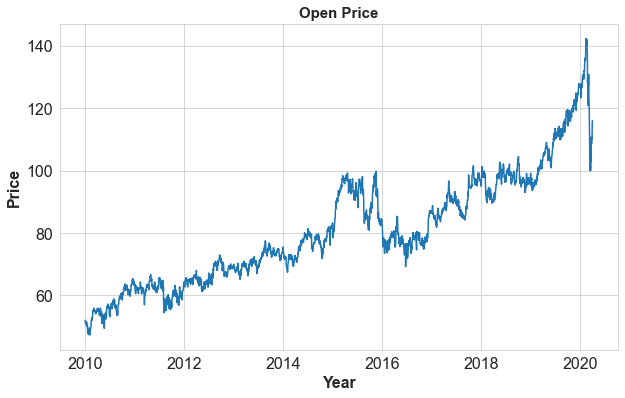

In [7]:
# Line plot
fig, ax = plt.subplots(figsize=(10, 6))
sns.lineplot(air_liquide['Date'], air_liquide['Open'] )

# Formatting
ax.set_title('Open Price', fontsize = 15, loc='center', fontdict=dict(weight='bold'))
ax.set_xlabel('Year', fontsize = 16, fontdict=dict(weight='bold'))
ax.set_ylabel('Price', fontsize = 16, fontdict=dict(weight='bold'))
plt.tick_params(axis='y', which='major', labelsize=16)
plt.tick_params(axis='x', which='major', labelsize=16)

In [8]:
# Let's check NaN 
air_liquide.isna().sum()

Name               0
Date               0
Open               1
Closing_Price      0
Daily_High         0
Daily_Low          0
Volume           134
Year               0
Month              0
dtype: int64

In [9]:
# Get index of the missing value in Open column
index_open_missing = air_liquide[pd.isnull(air_liquide['Open'])].index
print(list(index_open_missing)[0])

4538


In [10]:
# I replace the missing value by the Open price value of the previous day (backward fill)
air_liquide['Open'] = air_liquide['Open'].fillna(method='bfill')

In [11]:
print(f"Percentage of missing values in Volume: {round(sum(pd.isnull(air_liquide['Volume']))/air_liquide.shape[0],2)}\n")
print(air_liquide[air_liquide['Volume']==0])

Percentage of missing values in Volume: 0.05

Empty DataFrame
Columns: [Name, Date, Open, Closing_Price, Daily_High, Daily_Low, Volume, Year, Month]
Index: []


In [12]:
# Imputation
imputer = SimpleImputer(strategy='constant', fill_value=0)
air_liquide_plus = imputer.fit_transform(air_liquide)

# Imputation removed column names; put them back
imputed_air_liquide = pd.DataFrame(air_liquide_plus)
imputed_air_liquide.columns = air_liquide.columns

In [13]:
# Replace , by . so Volume can be converted as float
imputed_air_liquide['Volume'] = imputed_air_liquide['Volume'].apply(lambda x : str(x))
imputed_air_liquide['Volume'] = pd.to_numeric(imputed_air_liquide['Volume'].apply(lambda x : x.replace(',','',1)))

# Convert object to numeric 
imputed_air_liquide['Open'] = pd.to_numeric(imputed_air_liquide['Open'])
imputed_air_liquide['Closing_Price'] = pd.to_numeric(imputed_air_liquide['Closing_Price'])
imputed_air_liquide['Daily_High'] = pd.to_numeric(imputed_air_liquide['Daily_High'])
imputed_air_liquide['Daily_Low'] = pd.to_numeric(imputed_air_liquide['Daily_Low'])

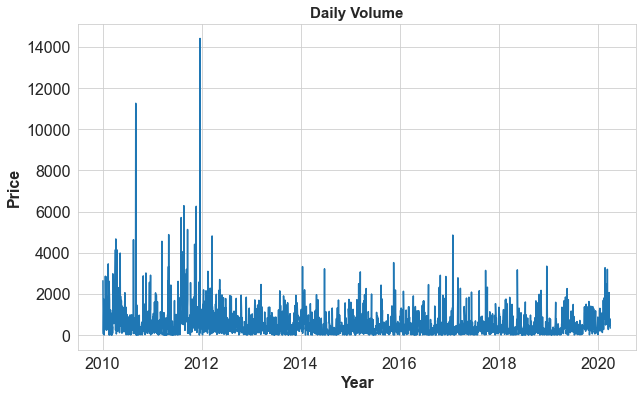

In [14]:
# Plot Daily Volume Lineplot
fig, ax = plt.subplots(figsize=(10, 6))
sns.lineplot(imputed_air_liquide['Date'], imputed_air_liquide['Volume'] )

ax.set_title('Daily Volume', fontsize = 15, loc='center', fontdict=dict(weight='bold'))
ax.set_xlabel('Year', fontsize = 16, fontdict=dict(weight='bold'))
ax.set_ylabel('Price', fontsize = 16, fontdict=dict(weight='bold'))
plt.tick_params(axis='y', which='major', labelsize=16)
plt.tick_params(axis='x', which='major', labelsize=16)

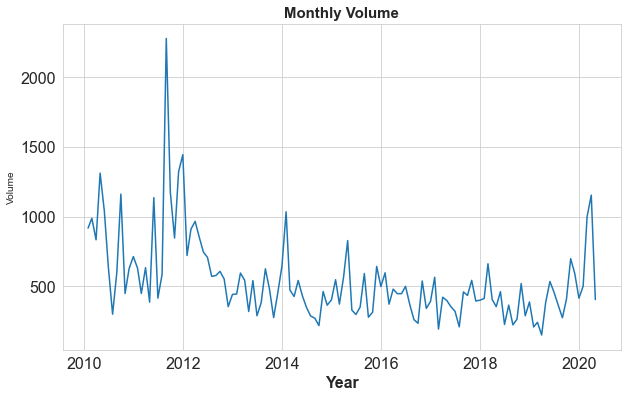

In [15]:
# Aggregating the Time Series to a monthly scaled index
y = imputed_air_liquide[['Date','Volume']].copy()
y.set_index('Date', inplace=True)
y.index = pd.to_datetime(y.index)
y = y.resample('1M').mean()
y['Date'] = y.index

# Plot the Monthly Volume Lineplot
fig, ax = plt.subplots(figsize=(10, 6))
sns.lineplot(y['Date'], y['Volume'] )
ax.set_title('Monthly Volume', fontsize = 15, loc='center', fontdict=dict(weight='bold'))
ax.set_xlabel('Year', fontsize = 16, fontdict=dict(weight='bold'))
plt.tick_params(axis='y', which='major', labelsize=16)
plt.tick_params(axis='x', which='major', labelsize=16)

# seasonality

In [16]:
imputed_air_liquide['Year'] = imputed_air_liquide['Date'].dt.year
imputed_air_liquide['Month'] = imputed_air_liquide['Date'].dt.month

In [17]:
imputed_air_liquide['Year'].unique()

array([2020, 2019, 2018, 2017, 2016, 2015, 2014, 2013, 2012, 2011, 2010],
      dtype=int64)

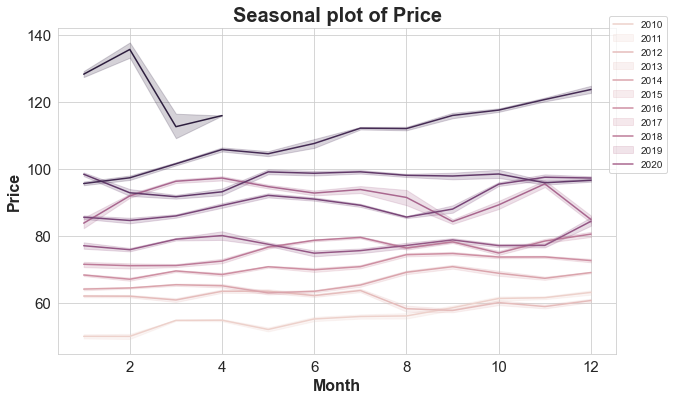

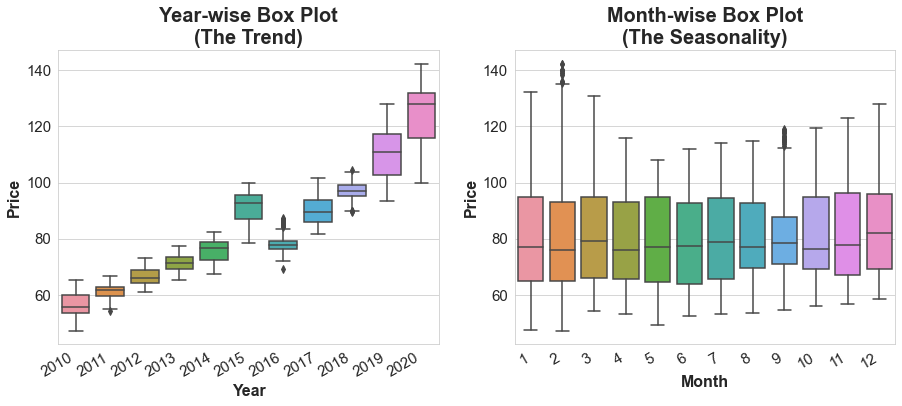

In [18]:
variable = 'Open'
fig, ax = plt.subplots(figsize=(10, 6))

sns.lineplot(imputed_air_liquide['Month'], imputed_air_liquide[variable], hue = imputed_air_liquide['Year'])
ax.set_title('Seasonal plot of Price', fontsize = 20, loc='center', fontdict=dict(weight='bold'))
ax.set_xlabel('Month', fontsize = 16, fontdict=dict(weight='bold'))
ax.set_ylabel('Price', fontsize = 16, fontdict=dict(weight='bold'))
ax.legend(labels = [str(2010+i) for i in range(11)], bbox_to_anchor=(1.1, 1.05))

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))
sns.boxplot(imputed_air_liquide['Year'], imputed_air_liquide[variable], ax=ax[0])
ax[0].set_title('Year-wise Box Plot\n(The Trend)', fontsize = 20, loc='center', fontdict=dict(weight='bold'))
ax[0].set_xlabel('Year', fontsize = 16, fontdict=dict(weight='bold'))
ax[0].set_ylabel('Price', fontsize = 16, fontdict=dict(weight='bold'))

sns.boxplot(imputed_air_liquide['Month'], imputed_air_liquide[variable], ax=ax[1])
ax[1].set_title('Month-wise Box Plot\n(The Seasonality)', fontsize = 20, loc='center', fontdict=dict(weight='bold'))
ax[1].set_xlabel('Month', fontsize = 16, fontdict=dict(weight='bold'))
ax[1].set_ylabel('Price', fontsize = 16, fontdict=dict(weight='bold'))

fig.autofmt_xdate()

Text(0, 0.5, 'Closing_Price')

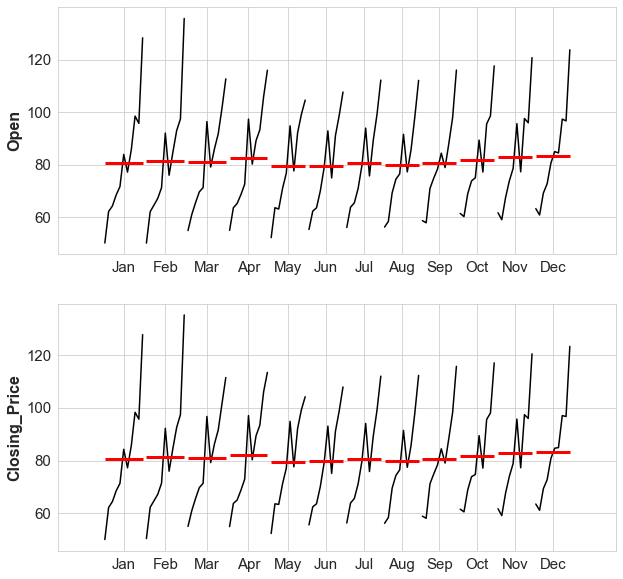

In [19]:
# Aggregating the Time Series to a monthly scaled index
y = imputed_air_liquide[['Date','Open','Closing_Price']].copy()
y.set_index('Date', inplace=True)
y.index = pd.to_datetime(y.index)
y = y.resample('1M').mean()

# The magic
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(10, 10))

month_plot(y['Open'], ax=ax[0]);
ax[0].set_ylabel('Open', fontsize = 16, fontdict=dict(weight='bold'))

month_plot(y['Closing_Price'], ax=ax[1]);
ax[1].set_ylabel('Closing_Price', fontsize = 16, fontdict=dict(weight='bold'))

Text(0.5, 0.98, 'Open decomposition')

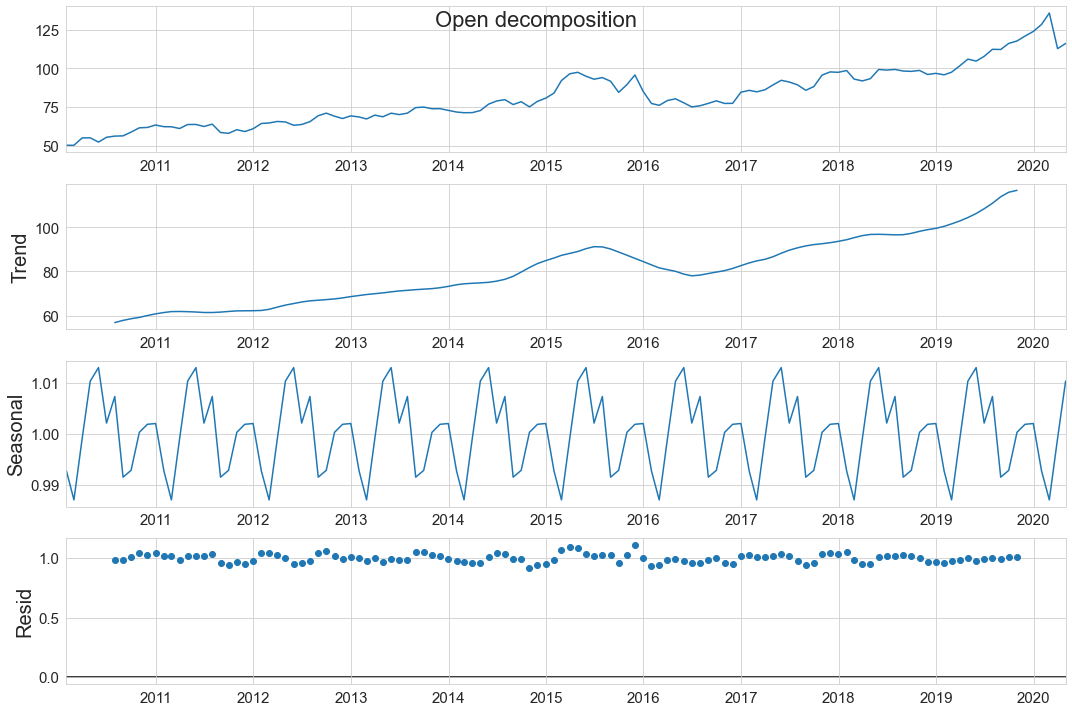

In [20]:
# Aggregating the Time Series to a monthly scaled index
y = imputed_air_liquide[['Date','Open']].copy()
y.set_index('Date', inplace=True)
y.index = pd.to_datetime(y.index)
y = y.resample('1M').mean()

# Setting rcparams
rcParams['figure.figsize'] = 15, 10
rcParams['axes.labelsize'] = 20
rcParams['ytick.labelsize'] = 15
rcParams['xtick.labelsize'] = 15

# Using statistical tools of statsmodel library
decomposition = sm.tsa.seasonal_decompose(y, model='multiplicative')
decomp = decomposition.plot()
decomp.suptitle('Open decomposition', fontsize=22)

# stationarity

In [21]:
# check for stationarity
def adf_test(series, title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print('Augmented Dickey-Fuller Test: {}'.format(title))
    # .dropna() handles differenced data
    result = adfuller(series.dropna(),autolag='AIC') 
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)
    for key,val in result[4].items():
        out['critical value ({})'.format(key)]=val
        
    # .to_string() removes the line "dtype: float64"
    print(out.to_string())          
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")
        
# Aggregating the Time Series to a monthly scaled index
y = imputed_air_liquide[['Date','Open']].copy()
y.set_index('Date', inplace=True)
y.index = pd.to_datetime(y.index)
y = y.resample('1M').mean()
        
adf_test(y['Open'],title='') 

Augmented Dickey-Fuller Test: 
ADF test statistic       -0.196686
p-value                   0.938915
# lags used               2.000000
# observations          121.000000
critical value (1%)      -3.485585
critical value (5%)      -2.885739
critical value (10%)     -2.579676
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary


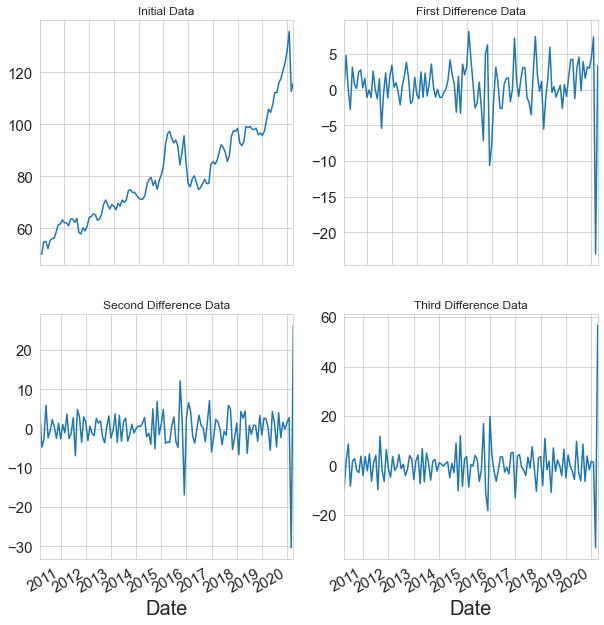

In [22]:
fig, ax = plt.subplots(nrows=2, ncols=2,figsize=(10, 11))

y['OpenDiff1'] = diff(y['Open'],k_diff=1)
y['OpenDiff2'] = diff(y['Open'],k_diff=2)
y['OpenDiff3'] = diff(y['Open'],k_diff=3)

y['Open'].plot(title="Initial Data",ax=ax[0][0]).autoscale(axis='x',tight=True);
y['OpenDiff1'].plot(title="First Difference Data",ax=ax[0][1]).autoscale(axis='x',tight=True);
y['OpenDiff2'].plot(title="Second Difference Data",ax=ax[1][0]).autoscale(axis='x',tight=True);
y['OpenDiff3'].plot(title="Third Difference Data",ax=ax[1][1]).autoscale(axis='x',tight=True);

fig.autofmt_xdate()


# autocorrelation

[1.         0.99669167 0.99397744 0.99114807 0.98842329 0.98574882
 0.98327505 0.98065432 0.97792933 0.97569862 0.97316217 0.97091567
 0.96872365 0.96677005 0.96448024 0.96224729 0.95968184 0.95699272
 0.95423987 0.95126885 0.94815404 0.94479836 0.94160485 0.93854499
 0.93560843 0.93284805 0.92976929 0.92688093 0.92378304 0.92046489
 0.91730545 0.91394706 0.91064856 0.90743726 0.90426107 0.90102265
 0.89772752 0.89464738 0.89163062 0.88862379 0.88584496 0.88294789
 0.88021878 0.87768629 0.87519469 0.87266679 0.87039248 0.86809038
 0.86572663 0.86328034 0.86084315 0.85844897 0.85612914 0.85390287
 0.85154451 0.84929882 0.84707093 0.84483261 0.84257198 0.84030894
 0.83812315]


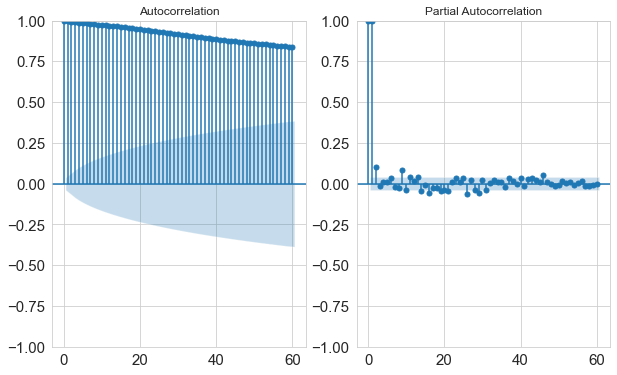

In [23]:
fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(10, 6))
autocorr = acf(imputed_air_liquide['Open'], nlags=60, fft=False)
print(autocorr)

plot_acf(imputed_air_liquide['Open'].tolist(), lags=60, ax=ax[0], fft=False);
plot_pacf(imputed_air_liquide['Open'].tolist(), lags=60, ax=ax[1]);

# lag scatter plot

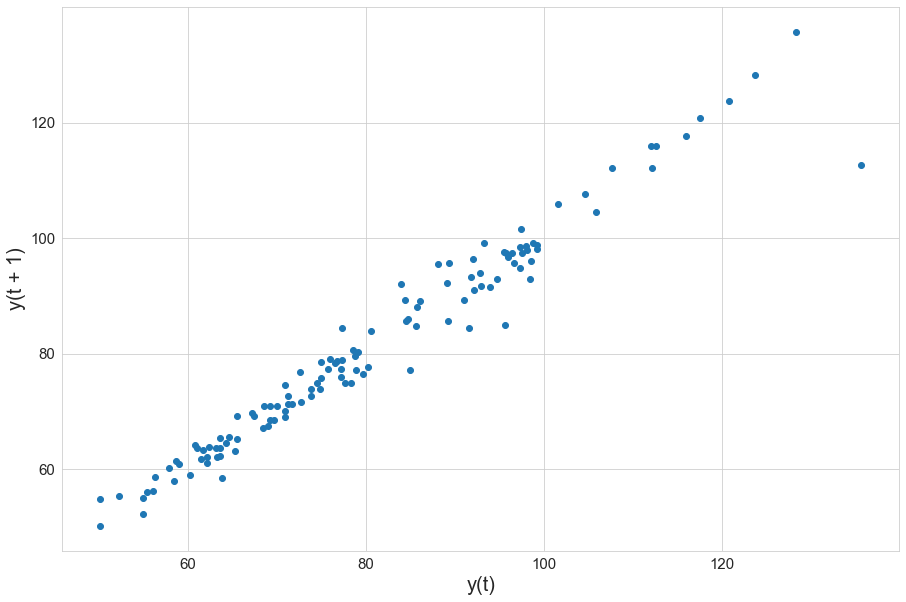

In [24]:
lag_plot(y['Open']);

# moving average

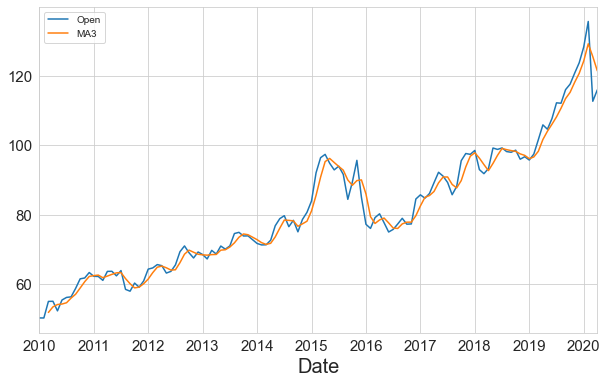

In [25]:
# Aggregating the Time Series to a monthly scaled index
y = imputed_air_liquide[['Date','Open']].copy()
y.set_index('Date', inplace=True)
y.index = pd.to_datetime(y.index)
y = y.resample('1M').mean()

y['MA3'] = y.rolling(window=3).mean() 
y.plot(figsize=(10,6));

# exponential smoothning

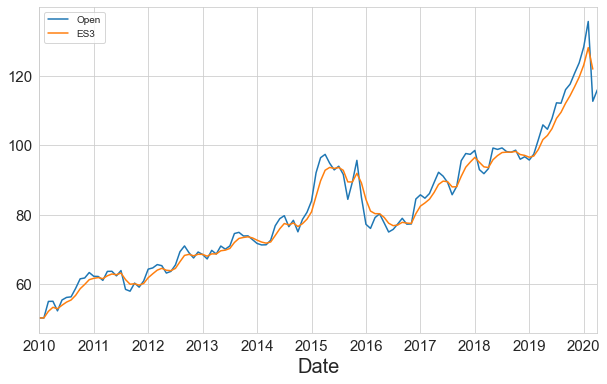

In [26]:
# Setting parameters value
span = 4
# Weights of observations
alpha = 2/(span+1)
# Plot Simple exponential smoothing
y['ES3'] = SimpleExpSmoothing(y['Open']).fit(smoothing_level = alpha, optimized = False).fittedvalues.shift(-1)
y[['Open','ES3']].plot(figsize=(10,6));

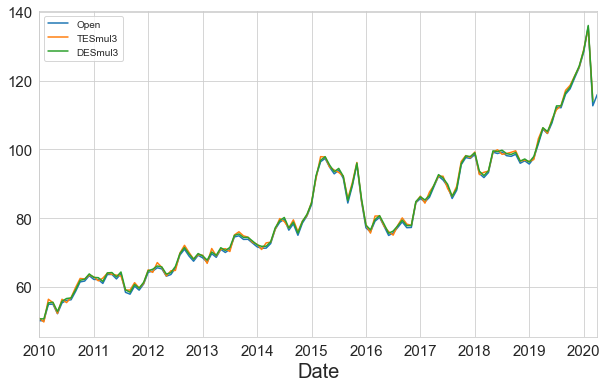

In [29]:
# Plot Double and Triple exponential smoothing
y['DESmul3'] = ExponentialSmoothing(y['Open'], trend = 'add').fit().fittedvalues.shift(-1)
y['TESmul3'] = ExponentialSmoothing(y['Open'], trend = 'add', seasonal = 'add', seasonal_periods = 12).fit().fittedvalues.shift(-1)
y[['Open', 'TESmul3', 'DESmul3']].plot(figsize = (10,6));

# auto arima

In [30]:
# Reverse index so the dataframe is from oldest to newest values
imputed_air_liquide = imputed_air_liquide.reindex(index=imputed_air_liquide.index[::-1])

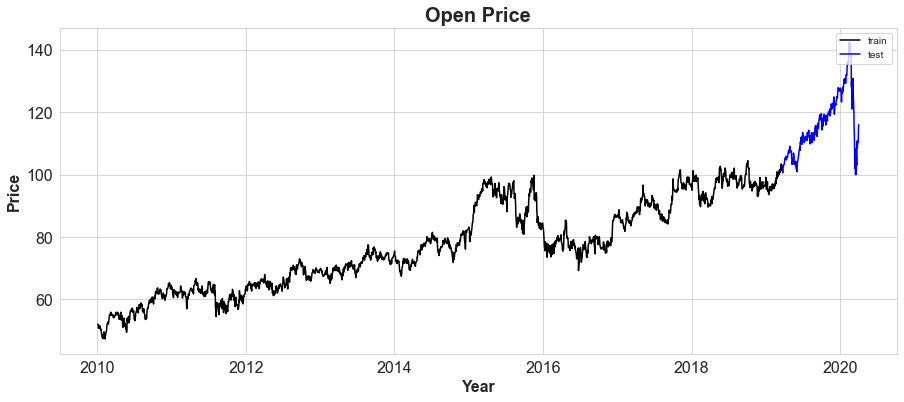

In [31]:
# Split data into train and validation set 90/10
air_liquide_train, air_liquide_val = imputed_air_liquide[:int(len(imputed_air_liquide)*0.9)], imputed_air_liquide[int(len(imputed_air_liquide)*0.9):]

# Index disappeared, put them back
air_liquide_val = air_liquide_val.set_index('Date', drop=False)
air_liquide_train = air_liquide_train.set_index('Date', drop=False)

# Line plot
fig, ax = plt.subplots(figsize=(15, 6))
sns.lineplot(air_liquide_train['Date'], air_liquide_train['Open'], color = 'black')
sns.lineplot(air_liquide_val['Date'], air_liquide_val['Open'], color = 'blue')

# Formatting
ax.set_title('Open Price', fontsize = 20, loc='center', fontdict=dict(weight='bold'))
ax.set_xlabel('Year', fontsize = 16, fontdict=dict(weight='bold'))
ax.set_ylabel('Price', fontsize = 16, fontdict=dict(weight='bold'))
plt.tick_params(axis='y', which='major', labelsize=16)
plt.tick_params(axis='x', which='major', labelsize=16)
plt.legend(loc='upper right' ,labels = ('train', 'test'))


In [32]:
%%time
model_autoARIMA = auto_arima(air_liquide_train['Open'])

""", 
                             start_p = 0, 
                             start_q = 0,
                             test = 'adf', # use adftest to find optimal 'd'
                             max_p = 3,
                             max_q = 3, # maximum p and q
                             m = 7, # frequency of series
                             seasonal = False,
                             start_P = 0, 
                             D = 0, 
                             trace = True,
                             error_action = 'ignore',  
                             stepwise = True
"""

print(model_autoARIMA.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 2340
Model:               SARIMAX(2, 1, 1)   Log Likelihood               -3405.792
Date:                Thu, 24 Nov 2022   AIC                           6821.584
Time:                        18:03:38   BIC                           6850.371
Sample:                             0   HQIC                          6832.070
                               - 2340                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0007      0.000      1.708      0.088      -0.000       0.002
ar.L1          0.8528      0.019     45.696      0.000       0.816       0.889
ar.L2          0.1114      0.017      6.644      0.0

In [33]:
model = sm.tsa.arima.ARIMA(air_liquide_train['Open'], order=(2,1,0))
result = model.fit()
print(result.summary())

                               SARIMAX Results                                
Dep. Variable:                   Open   No. Observations:                 2340
Model:                 ARIMA(2, 1, 0)   Log Likelihood               -3410.142
Date:                Thu, 24 Nov 2022   AIC                           6826.284
Time:                        18:03:38   BIC                           6843.556
Sample:                             0   HQIC                          6832.576
                               - 2340                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1297      0.016     -8.106      0.000      -0.161      -0.098
ar.L2         -0.0320      0.018     -1.792      0.073      -0.067       0.003
sigma2         1.0811      0.020     54.995      0.0

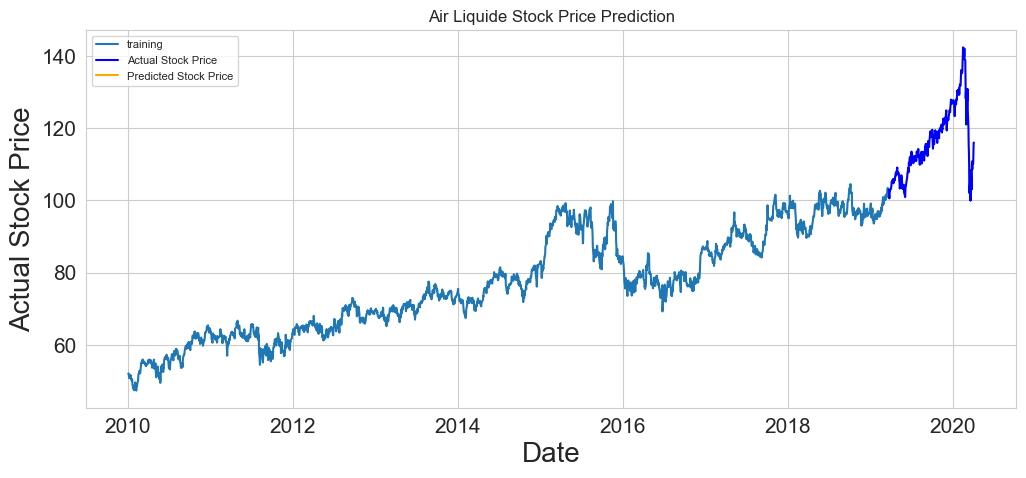

In [34]:
# Forecast 260 next observations 
fc = result.forecast(260, alpha=0.05)  # 95% confidence
fc_series = pd.Series(fc, index=air_liquide_val.index)


plt.figure(figsize=(12,5), dpi=100)
plt.plot(air_liquide_train['Open'], label='training')
plt.plot(air_liquide_val['Open'], color = 'blue', label='Actual Stock Price')
plt.plot(fc_series, color = 'orange',label='Predicted Stock Price')

plt.title('Air Liquide Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Actual Stock Price')
plt.legend(loc='upper left', fontsize=8)
plt.show()


In [35]:
import math

In [36]:
# Report performance
mse = mean_squared_error(air_liquide_val['Open'], fc)
print('MSE: '+str(mse))
mae = mean_absolute_error(air_liquide_val['Open'], fc)
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(air_liquide_val['Open'], fc))
print('RMSE: '+str(rmse))
mape = np.mean(np.abs(fc - air_liquide_val['Open'])/np.abs(air_liquide_val['Open']))
print('MAPE: '+str(mape))

MSE: 280.4606249772666
MAE: 13.779298237417953
RMSE: 16.74695867843671
MAPE: nan


# exponential

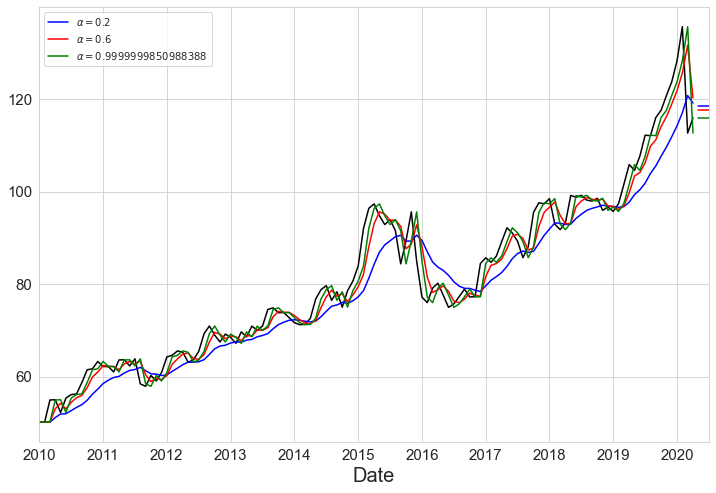

In [41]:
fit1 = SimpleExpSmoothing(y['Open']).fit(smoothing_level=0.2,optimized=False)
fcast1 = fit1.forecast(3).rename(r'$\alpha=0.2$')
fit2 = SimpleExpSmoothing(y['Open']).fit(smoothing_level=0.6,optimized=False)
fcast2 = fit2.forecast(3).rename(r'$\alpha=0.6$')
fit3 = SimpleExpSmoothing(y['Open']).fit()
fcast3 = fit3.forecast(3).rename(r'$\alpha=%s$'%fit3.model.params['smoothing_level'])

ax = y['Open'].plot( color='black', figsize=(12,8))
fcast1.plot( ax=ax, color='blue', legend=True)
fit1.fittedvalues.plot (ax=ax, color='blue')
fcast2.plot( ax=ax, color='red', legend=True)

fit2.fittedvalues.plot( ax=ax, color='red')
fcast3.plot( ax=ax, color='green', legend=True)
fit3.fittedvalues.plot( ax=ax, color='green')
plt.show()

In [42]:
#mse

X = air_liquide['Open']

testX = X.iloc[-30:]
trainX = X.iloc[:-30]

In [44]:
def mean_absolute_percentage_error_func(y_true, y_pred):
    '''
    Calculate the mean absolute percentage error as a metric for evaluation
    
    Args:
        y_true (float64): Y values for the dependent variable (test part), numpy array of floats 
        y_pred (float64): Predicted values for the dependen variable (test parrt), numpy array of floats
    
    Returns:
        Mean absolute percentage error 
    '''    
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [46]:
def timeseries_evaluation_metrics_func(y_true, y_pred):
    '''
    Calculate the following evaluation metrics:
        - MSE
        - MAE
        - RMSE
        - MAPE
        - R²
    
    Args:
        y_true (float64): Y values for the dependent variable (test part), numpy array of floats 
        y_pred (float64): Predicted values for the dependen variable (test parrt), numpy array of floats
    
    Returns:
        MSE, MAE, RMSE, MAPE and R² 
    '''    
    print('Evaluation metric results: ')
    print(f'MSE is : {metrics.mean_squared_error(y_true, y_pred)}')
    print(f'MAE is : {metrics.mean_absolute_error(y_true, y_pred)}')
    print(f'RMSE is : {np.sqrt(metrics.mean_squared_error(y_true, y_pred))}')
    print(f'MAPE is : {mean_absolute_percentage_error_func(y_true, y_pred)}')
    print(f'R2 is : {metrics.r2_score(y_true, y_pred)}',end='\n\n')

In [51]:
import pandas as pd
import numpy as np
from sklearn import metrics

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import ParameterGrid

from statsmodels.tsa.api import SimpleExpSmoothing
from statsmodels.tsa.api import Holt
from statsmodels.tsa.api import ExponentialSmoothing

In [53]:
resu = []
temp_df = pd.DataFrame()
for i in [ 0.10, 0.20, 0.30,  0.50, 0.80, 0.90]:
    print(f'Fitting for smoothing level= {i}')
    fit_v = SimpleExpSmoothing(np.asarray(trainX)).fit(i)
    fcst_pred_v= fit_v.forecast(len(testX))   
    timeseries_evaluation_metrics_func(testX, fcst_pred_v)

Fitting for smoothing level= 0.1
Evaluation metric results: 
MSE is : 11.881690773013066
MAE is : 3.1317896189650916
RMSE is : 3.446982850699009
MAPE is : 6.396662791672833
R2 is : -4.730024725145446

Fitting for smoothing level= 0.2
Evaluation metric results: 
MSE is : 6.29931904149156
MAE is : 2.1045934739525403
RMSE is : 2.509844425754624
MAPE is : 4.321480433341507
R2 is : -2.037888676694857

Fitting for smoothing level= 0.3
Evaluation metric results: 
MSE is : 4.280994040898238
MAE is : 1.7025078676010676
RMSE is : 2.069056316512008
MAPE is : 3.4968665986291105
R2 is : -1.064537966116975

Fitting for smoothing level= 0.5
Evaluation metric results: 
MSE is : 2.876109141333737
MAE is : 1.4350568996766369
RMSE is : 1.6959095321784523
MAPE is : 2.93423740852511
R2 is : -0.3870228410160823

Fitting for smoothing level= 0.8
Evaluation metric results: 
MSE is : 2.309657189727122
MAE is : 1.328094186290642
RMSE is : 1.5197556348726338
MAPE is : 2.698924916409467
R2 is : -0.113847604400351